# Ginkgo clustering environment

## Setup

In [1]:
%matplotlib inline

import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO2
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DWrapper


/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/johannbrehmer/anaconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/johannbrehmer/anaconda3/env

In [2]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [3]:
# Initial setup
env = gym.make("GinkgoLikelihood-v0")
state = env.reset()
env.render()

14:31 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
14:31 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 12 leaves
14:31 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
14:31 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 10 leaves
14:31 ginkgo_rl.envs.ginkg INFO    10 particles:
14:31 ginkgo_rl.envs.ginkg INFO      p[ 0] = (189.6, 112.4, 100.7, 114.9)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 1] = ( 44.0,  25.0,  23.8,  27.2)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 2] = ( 32.8,  21.3,  18.3,  16.6)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  5.3,   3.1,   2.8,   3.3)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 4] = ( 21.0,  12.4,  11.7,  11.6)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  8.0,   7.6,   1.6,   0.5)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 6] = (  7.6,   6.4,   3.8,   0.6)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 7] = (  4.4,   0.7,   3.6,   2.0)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 8] = ( 11.7,   7.6,   6.3,   5.5)
14:31 ginkgo_rl.envs.ginkg INFO   

In [4]:
# Merge two particles
action = 0, 1

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


14:31 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (0, 1)
14:31 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (0, 1): -8.7150239944458
14:31 ginkgo_rl.envs.ginkg DEBUG   Merging particles 0 and 1. New state has 9 particles.
14:31 ginkgo_rl.envs.ginkg INFO    9 particles:
14:31 ginkgo_rl.envs.ginkg INFO      p[ 0] = (233.7, 137.4, 124.5, 142.0)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 1] = ( 32.8,  21.3,  18.3,  16.6)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  5.3,   3.1,   2.8,   3.3)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 3] = ( 21.0,  12.4,  11.7,  11.6)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  8.0,   7.6,   1.6,   0.5)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 5] = (  7.6,   6.4,   3.8,   0.6)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 6] = (  4.4,   0.7,   3.6,   2.0)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 7] = ( 11.7,   7.6,   6.3,   5.5)
14:31 ginkgo_rl.envs.ginkg INFO      p[ 8] = ( 83.5,  34.6,  58.2,  48.8)


Reward: -8.7150239944458
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 0, 'j': 1}


## Reward distribution for random actions

In [5]:
env.action_space

Tuple(Discrete(30), Discrete(30))

In [6]:
env.action_space.sample()

(19, 1)

In [14]:
n_steps = 10000

set_output(False)
env = gym.make("GinkgoLikelihood1D-v0")
state = env.reset()
rewards, legal = [], []

for _ in range(n_steps):
    action = env.action_space.sample()
    legal.append(env.check_legality(action))
    _, reward, _, _ = env.step(action)
    rewards.append(reward)


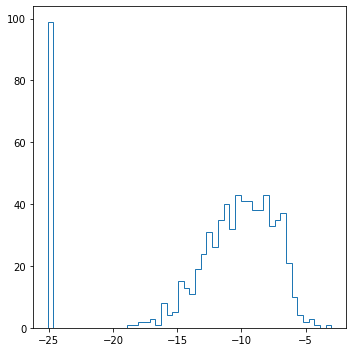

In [15]:
range_ = (-25.1, -3)

rewards = np.asarray(rewards)
legal = np.asarray(legal)

fig = plt.figure(figsize=(5,5))
# plt.hist(rewards, range=range_, bins=50, histtype="step")
plt.hist(rewards[legal], range=range_, bins=50, histtype="step")
plt.tight_layout()
plt.show()


## Let's let some RL agents loose! First, PPO

In [9]:
n_steps = 100000
log_dir = "./logs/ppo/"

set_output(False)
env = gym.make("GinkgoLikelihood1D-v0")
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

model = PPO2(MlpPolicy, env, verbose=0)
model.learn(total_timesteps=n_steps)
env.close()


------------------------------


/Users/johannbrehmer/work/projects/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------
------------------------------


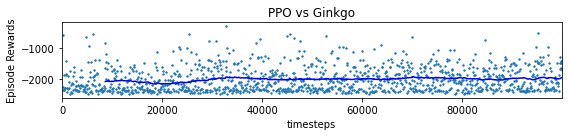

In [10]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "PPO vs Ginkgo")


In [16]:
set_output(True)

state = env.reset()
done = False
steps = 0

while not done and steps < int(1.e5):
    action, _states = model.predict(state)
    obs, reward, done, info = env.step(action)
    env.render()
    steps += 1


15:33 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
15:33 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 12 leaves
15:33 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (4, 0)
15:33 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (4, 0): -25.0
15:33 ginkgo_rl.envs.ginkg DEBUG   Merging particles 4 and 0. New state has 11 particles.
15:33 ginkgo_rl.envs.ginkg INFO    11 particles:
15:33 ginkgo_rl.envs.ginkg INFO      p[ 0] = ( 10.2,   2.2,   7.4,   6.6)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  7.4,   5.3,  -0.7,   5.0)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  7.2,   4.4,   0.5,   4.4)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 3] = ( 74.2,  35.1,  40.5,  51.3)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 4] = (  0.8,   0.6,   0.4,   0.3)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 5] = ( 62.8,  33.6,  35.9,  39.0)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 6] = ( 30.8,  16.6,  15.6,  20.5)
15:33 ginkgo_rl.envs.ginkg INFO      p[ 7] = (  4.5,   2.5,   2.4, 